In [20]:
import numpy as np

def create_aha_masks(
    image_shape,
    centre_point,
    ref_vector,
    location
):
    """
    Create angular AHA-style masks for a short-axis slice.

    Parameters
    ----------
    image_shape : (H, W)
    centre_point : (x0, y0)
    ref_vector : (vx, vy), LA -> septum direction
    location : str ("basal", "mid", "apical" or "apex_cap")

    Returns
    -------
    masks : ndarray of shape (num_segments, H, W) where num_segments is 1, 4, or 6 depending on location
    6-segment masks for "basal" and "mid", 4-segment masks for "apical", and 1-segment mask for "apex_cap".

    """

    H, W = image_shape
    x0, y0 = centre_point

    # Normalize reference vector
    ref = np.array(ref_vector, dtype=float)
    ref /= np.linalg.norm(ref)

    # Coordinate grid
    ys, xs = np.mgrid[0:H, 0:W]
    dx = xs - x0
    dy = ys - y0

    # Mask out centre pixel to avoid zero-length vectors
    mag = np.sqrt(dx**2 + dy**2)
    valid = mag > 0

    dx = dx.astype(float)
    dy = dy.astype(float)

    dx /= np.where(valid, mag, 1)
    dy /= np.where(valid, mag, 1)

    # Signed angle between ref and pixel vector
    dot = ref[0]*dx + ref[1]*dy
    cross = ref[0]*dy - ref[1]*dx
    angles = np.arctan2(cross, dot)  # [-pi, pi)

    if location == "basal":
        num_segments = 6
        seg_indices = [5, 4, 3, 2, 1, 6]  # AHA segment numbering
    elif location == "mid":
        num_segments = 6
        seg_indices = [11, 10, 9, 8, 7, 12]  # AHA segment numbering
    elif location == "apical":
        num_segments = 4
        seg_indices = [16, 15, 14, 13]  # AHA segment numbering
    elif location == "apex_cap":
        num_segments = 1
        seg_indices = [17]  # AHA segment numbering

    # masks = np.zeros((num_segments, H, W), dtype=bool)
    final_mask = np.zeros((H, W), dtype=int)
    if num_segments == 1:
        final_mask[:, :] = 17
        return final_mask

    if num_segments == 4:
        seg_width = np.pi / 2
        angles_shifted = angles + seg_width / 2
        seg_idx = np.floor(angles_shifted / seg_width).astype(int) % 4

    elif num_segments == 6:
        seg_width = np.pi / 3
        seg_idx = np.floor(angles / seg_width).astype(int) % 6

    else:
        raise ValueError("num_segments must be 1, 4, or 6")

    for s in range(num_segments):
        final_mask[seg_idx == s] = seg_indices[s]

    return final_mask

In [22]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

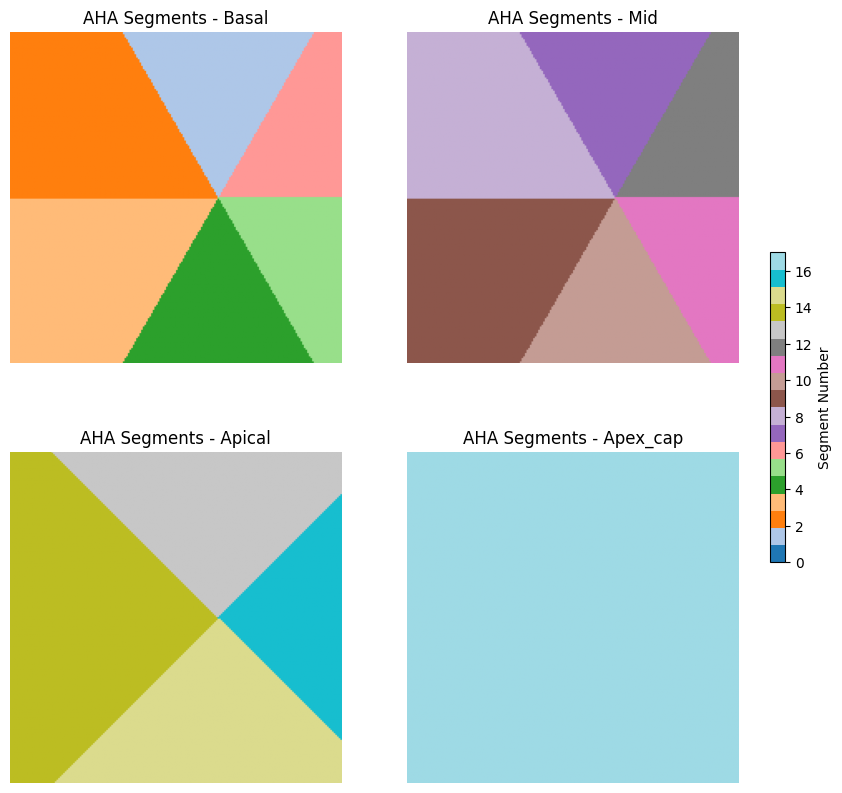

In [29]:
# plot and show example usage
fig, ax = plt.subplots(2, 2, figsize=(10,10))

base = plt.get_cmap("tab20")
colours = np.vstack([
    # [0,0,0,0],
    base(np.linspace(0, 1, 18))
])
cmap = ListedColormap(colours)

location_types = ['basal', 'mid', 'apical', 'apex_cap']
for i, loc in enumerate(location_types):
    masks = create_aha_masks((200, 200), (125, 100), (1, 0), loc)
    ax_i = ax[i//2, i%2]
    # combined_mask = np.zeros((200, 200), dtype=int)
    # for j in range(masks.shape[0]):
    #     combined_mask[masks[j]] = j + 1
    ax_i.imshow(masks, cmap=cmap, vmin=0, vmax=17)
    ax_i.set_title(f'AHA Segments - {loc.capitalize()}')
    ax_i.axis('off')

# add a colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=17)), ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Segment Number')
plt.show()

